# pyDPC4D_V1.0

By Xuyang (Rhett) Zhou, Max-Planck-Institut für Eisenforschung GmbH, x.zhou@mpie.de

pyDPC4D provides a systematic data processing approach for the atomic-resolution differential phase contrast - four-dimensional scanning transmission electron microscopy (DPC-4DSTEM) data sets. With this code, you can reconstruct the annual dark field, electric field, vector field divergence, (projected) electrostatic potential, and charge density images. 

I would like to thank Dr. Colin Ophus for his insightful discussion and help with coding.

To illustrate the workflow, I use an experimental Fe sigma-5 bicrystalline sample with boron/carbon interstitial solutions at the grain boundary. This process can also be applied to the simulated 4DSTEM data set.

# 0 Load modules

Important note: Run the following cell twice to avoid imaging issues.

In [1]:
## Figures in the jupyter notebook ########################################################################################
%matplotlib inline  
import matplotlib.pyplot as plt
from pyDPC4D import Pro

# 1 Load Data and define parameters

In [2]:
data_type = 'exp'               ## Define the type of data set, 'exp' (experiment) or 'sim' (simulation)
# data_type = 'sim'               ## Define the type of data set, 'exp' (experiment) or 'sim' (simulation)

## Mandotory information, which should be known during data collection ####################################################
thickness_nm = 15.0             ## This parameter is the thickness of the specimen, unit nm 
aperture_mrad = 23.6            ## probe aperture, semi-convergence angle, unit mrad 

## 1.1 Load data

In [3]:
if data_type == 'exp':
    ## Load experimental dataset; Our data was collected by EMPAD detector;
    ## Two files should be included in the folder: the *.raw file and the *.xml file.
    ## Note the *.xml file (scan information) should have the same name as the folder name 
    fold_name = 'G:/4DSTEM/20220414_Fe5B_02_01_71PV_pc/Fe5B_02_01_71PV_03/'
    file_in = 'scan_x128_y128.raw'
    ## The data size must be known in advance. 
    ## Note: The diffraction is not always 128*128, which changes with your detector.
    data_size = (128, 128, 130, 128)
    dataset,path,voltage_kV,real_scale_pm = Pro.initial_data_Process(fold_name,file_in,data_size)          
else:
    ## Load dataset; Our data was simulated by mustem.
    file_path_input = "//mufs4/x.zhou/TEM/muSTEM/Fe/Fe_5_310_B2_4d01/DiffBinned_128/datacube_DiffBinned_128.h5"
    dataset,path,fold_name = Pro.get_muSTEM_sim_data(file_path_input)
    voltage_kV =  300           ## Accelerating voltage used for simulation, unit kV
    a_pm = 1252.6               ## Lattice parameter for the horizontal direction of the super cell, unit pm
    real_scale_pm = Pro.get_real_scale_pm(a_pm,dataset)      ## Get the real space scale

## 1.2 Define parameters for the reconstruction

In [4]:
## Parameters for data processing  #######################################################################################
## FFT cleanning for reconstructed bright field or dark field images, reduce scanning noise (Optional)
fft_clean = 1                   ## If fft_clean = 1, use fft filter for ADF images, if = 0, raw image
fft_type = 'rectangular'        ## Type of fft filter, support 'rectangular', 'circle', 'gaussian'
fft_ratio = 0.35                ## Simplify the parameter of the filter into one value, range from 0 (strong) to 1 (weak)

## Parameters for drift correction (Optional)
drift_correction = 1            ## If drift_correction = 1, correct the image based on BF/DF images, if = 0, no correction
scale_ratio = 10.0              ## ratio to the original size, enlarge the original image to increase the pixel resolution 
apply_drift_correction = 1      ## If apply_drift_correction = 1, all the following image will be corrected

## Paramaters for crop region of interest (ROI) in the real space (Optional)
crop_image = 1                  ## If crop_image = 1, the user must select an area to crop, if = 0, skip cropping 
apply_crop_image = 5            ## If apply_crop_image = 0, no crop; if > 1, crop for ROI_x will be applied
crop_style = 6                  ## Define the initial shape of the crop rectangular                    
# If 1, 1/2 of height, 1/2 of width;
# If 2, 9/10 of height, 1/2 of width；
# If 3, 9/10 of height, 9/10 of width;
# If 4, 8/10 of height, 8/10 of width;
# If 5, 1/2 of height, 9/10 of width;
# If 6, 7/10 of height, 8/10 of width;
# If 7, 50 pixel of heigh, 75 pixel of width.

## FFT cleaning for the reconstructed images of the center of mass (CoM) of the BF disks, reduce scanning noise (Optional)
fft_clean_CoM = 1               ## If fft_clean_CoM = 1, use fft filter for CoM, if = 0, raw image
fft_type_CoM = 'rectangular'    ## Type of fft filter, support 'rectangular', 'circle', 'gaussian'
fft_ratio_CoM = 0.7             ## Simplify the parameter of the filter into one value, range from 0 (strong) to 1 (weak)
## Parameters for the reconstruction of CoM
flip_key = 1                    ## To flip the x and y axis for a correct reconstruction, 0 or 1.
rotation = 0                  ## To rotate the x and y axis for a correct reconstruction, -90,0,180.

## Parameters for setting a proper scale for the vector map
lkey = 0.1                      ## For vector map, legend, unit V/pm  
scalef = 0.02                   ## For vector map, Scale factor

## Parameters for the reconstructed electrostatic maps
G_blur = 3                      ## If G_blur = 0, no blur, guassian blur for the electrostatic maps
use_pass_filter_pot = 1         ## if 1, use pass filter for the potential map, if 0, no pass filter
lP = 0                          ## Low pass filter
hP = 0.1                        ## High pass filter

name_extra,name_extra_CoM = Pro.add_name_extra_hf(
                    fft_clean,fft_clean_CoM,apply_drift_correction,path,thickness_nm,aperture_mrad,flip_key,rotation)

# 2. Bright Field and Dark Field imaging (Overall, before crop)

## 2.1 Estimate radius of BF disk and show masks

Estimated probe radius = 11.77 pixels
Reciprocal scale (measured from the probe):1.02 (1/nm) / pixel
Reciprocal scale (measured from the probe):2.00 (mrad) / pixel


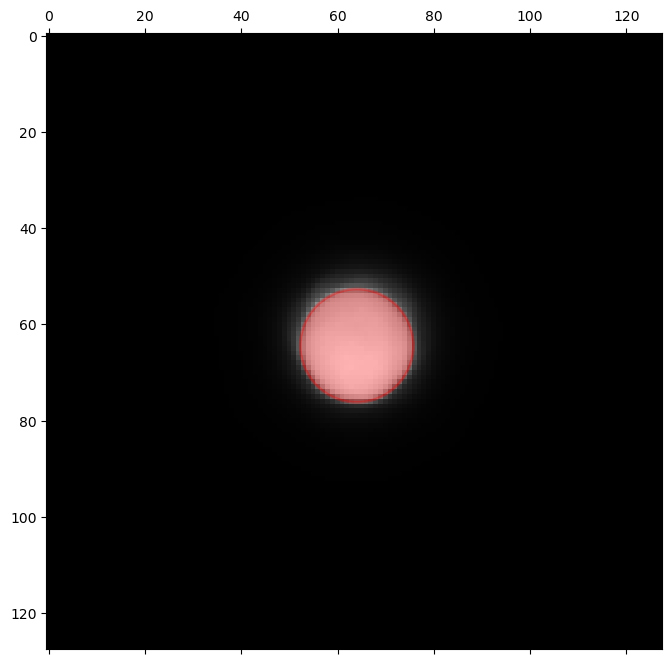

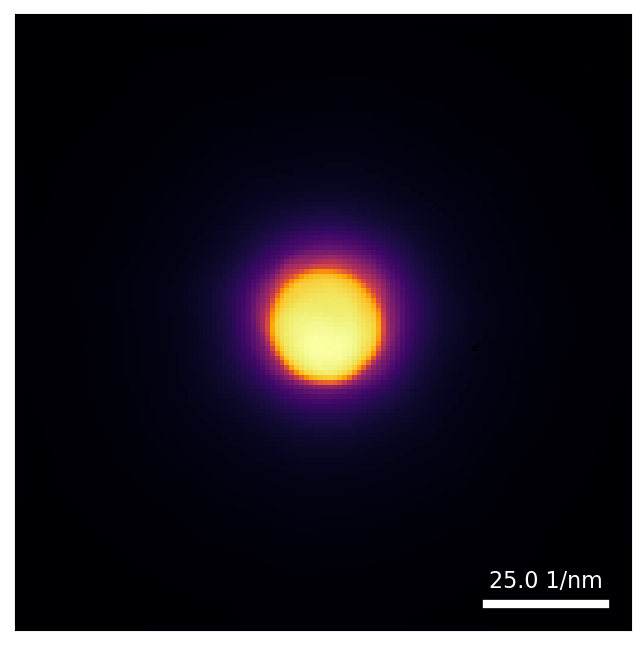

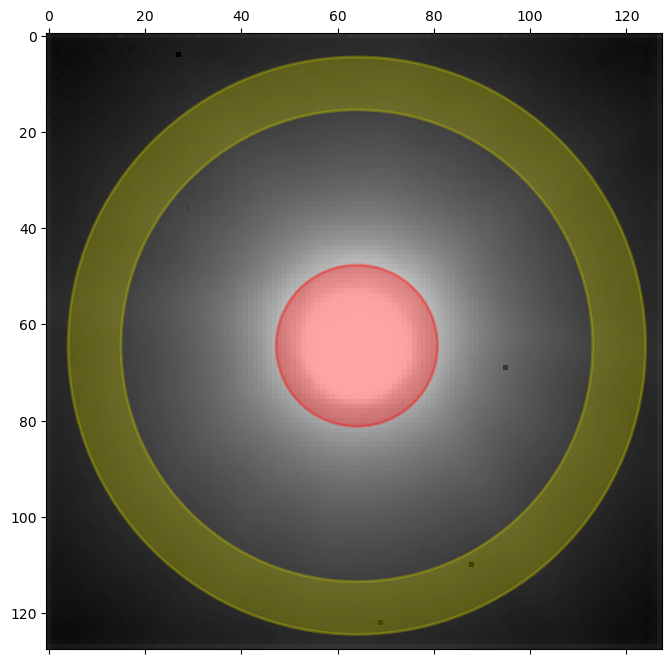

In [5]:
expand_BF = 5.0                 ## Paramater for the reconstruction of bright field image, unit pixel
det_DF = (49,60)                ## Parameters for the annular dark field image,(inner radius, outer radius), unit pixel 
probe_semiangle,qx0,qy0,mask,recip_scale_1nm,recip_scale_mrad,det_DF = Pro.show_diffraction_patterns(
                    dataset,path,aperture_mrad,voltage_kV,expand_BF,det_DF=det_DF)

## 2.2 Show BF and DF images

100%|█████████████████████████████████████████████████████████████████████████| 16384/16384 [00:00<00:00, 30424.93it/s]


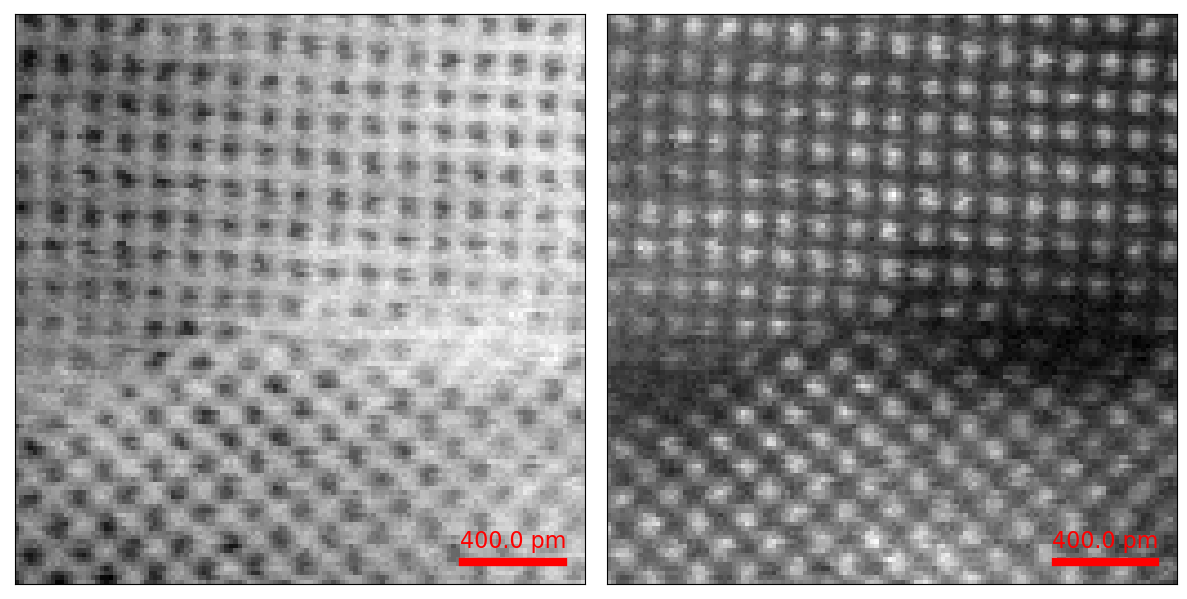

In [6]:
## Show bright field and dark filed images
image_BF, image_DF = Pro.show_raw_BF_DF_images(dataset,path,qx0, qy0,probe_semiangle,expand_BF,det_DF,real_scale_pm)

## 2.3 Show FFT cleaned BF nad DF images (Optional)

Here, a filter is applied in reciprocal space to remove the high frequency noise. 

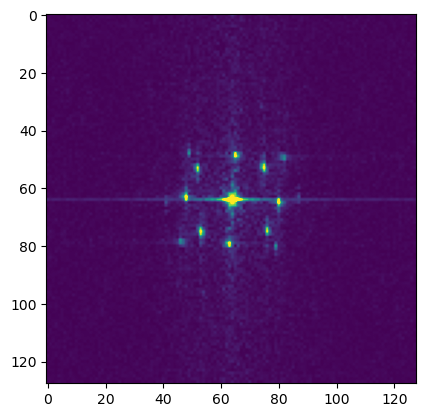

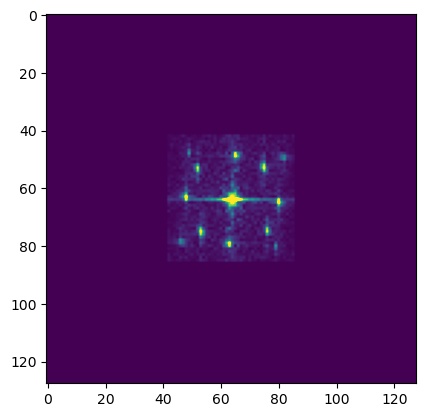

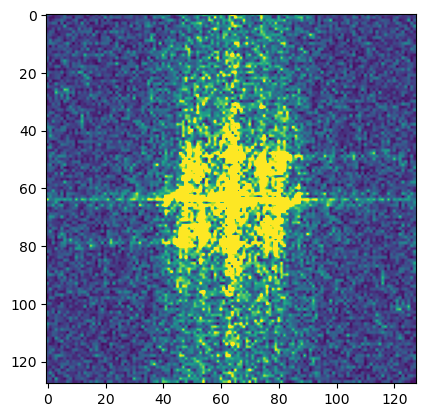

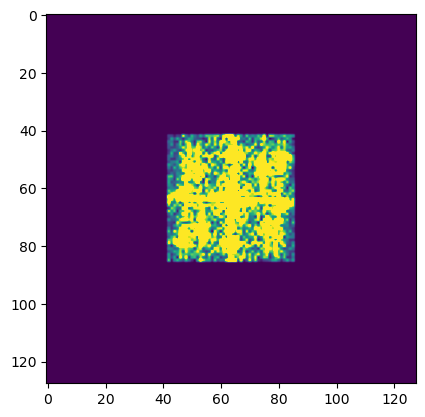

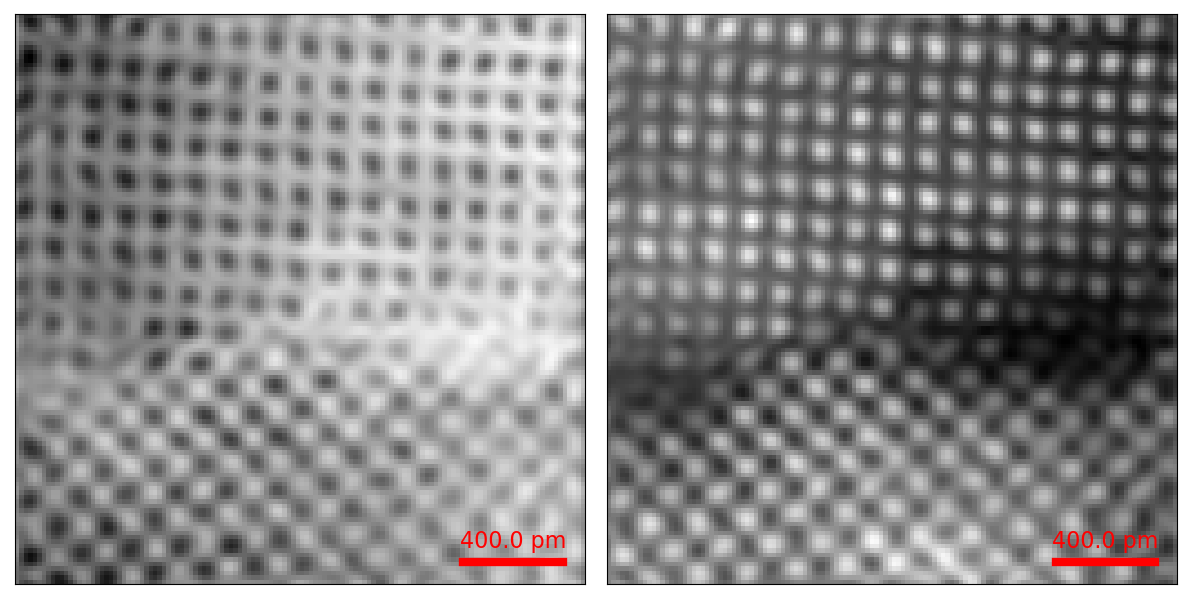

In [7]:
## Use fft to clean the images
if fft_clean == 1:
    image_BF, image_DF = Pro.BF_DF_fft(path,image_BF,image_DF,fft_type,fft_ratio,real_scale_pm,1)

# 3. Drift correction to remove scan distortion (Optional)

This function is used to manually correct the scan distortion. This function works only in case you have aligned the lattice parallel or perpendicular to the scan direction. By manually selecting some atom positions in the horizontal, a deformation is made to align the image according to the selected atom positions. After alignment in 'x' direction, the axis of 'x' and 'y' will be switched for alignment in the other direction. If you want to use this feature, you must run the code '%matplotlib notebook' or '%matplotlib' to enable interactive mode. This code does not work for the bicrystalline sample. However, to prove the principle, I would like to show how this function works. In the real data analysis, this step was skipped.   

## 3.1 Correct the drift in the 'x' direction

In [8]:
## The following code is to activate the interactive mode #################################################################
## Inline mode
%matplotlib notebook
## Or External window mode, need to run this code twice as following two lines
# %matplotlib
# %matplotlib

<IPython.core.display.Javascript object>


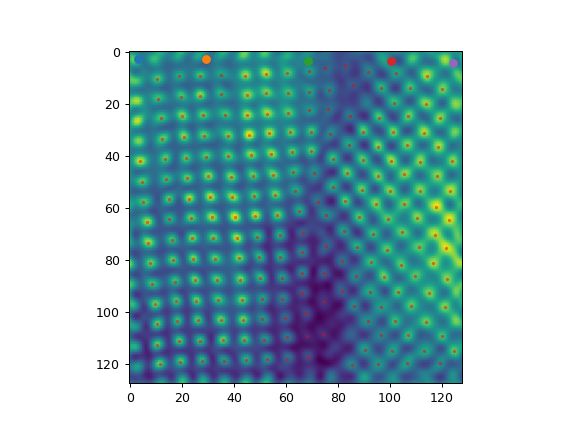

In [9]:
## Load image and click the image to select spots for the correction 
# Spots should form a nearly horizontal line across the image (ie. the colorful dots)
if drift_correction == 1:
    image = image_DF
    image = Pro.plot_image_points(image,1)  # the second parameter if 1, swip x and y

In [10]:
## After select spots, run the following script to correct the drift
if drift_correction == 1:
    image = Pro.apply_image_deformation(image,fold_name,'x',scale_ratio, 0)

## 3.2 Correct the drift in the 'y' direction

<IPython.core.display.Javascript object>


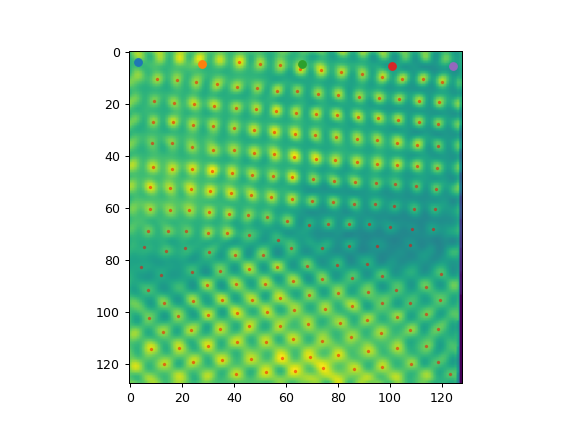

In [11]:
## Load image and select spots for the correction 
## Spots should form a nearly horizontal line across the image
if drift_correction == 1:
    image = Pro.plot_image_points(image,1)  # the second parameter if 1, swip x and y

<IPython.core.display.Javascript object>


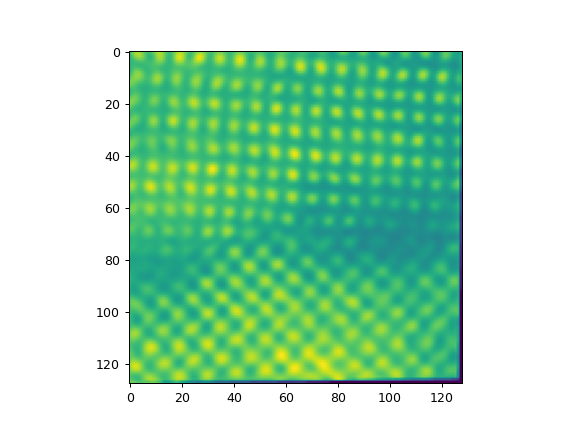

In [12]:
# #After select spots, run the following script to correct the drift
if drift_correction == 1:
    image = Pro.apply_image_deformation(image,fold_name,'y',scale_ratio, 1)

## 3.3 Save drift corrected BF and DF images

In [13]:
%matplotlib inline

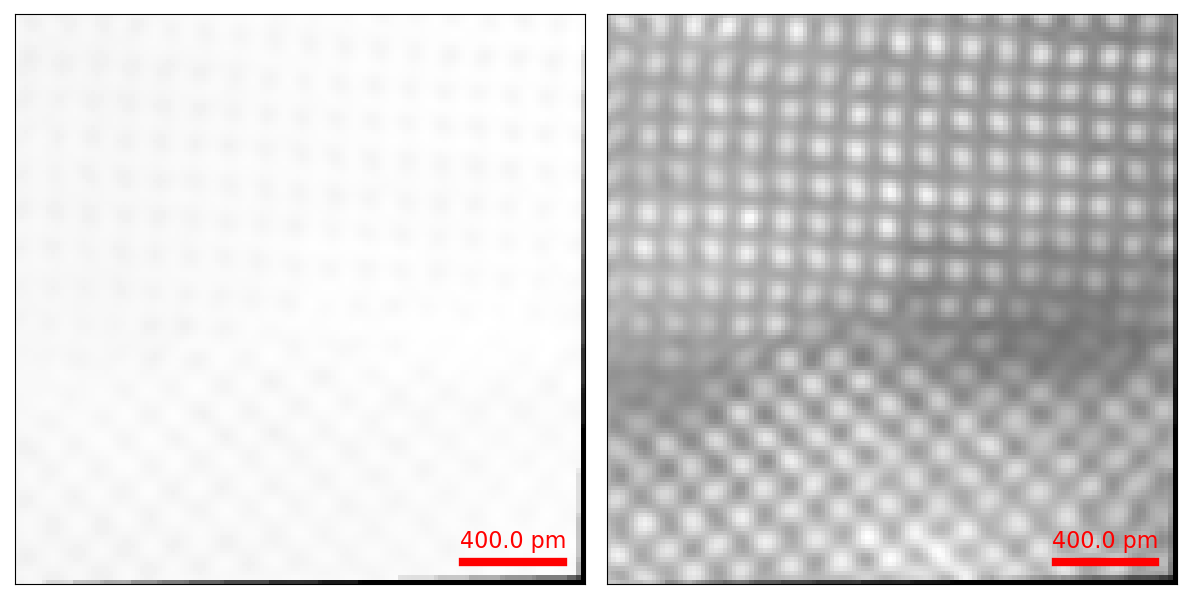

In [14]:
## Load drift corrected file for replotting the BF and DF images
if apply_drift_correction == 1:
    image_BF, image_DF = Pro.show_BF_DF_drift_corrected_images(
                path,fold_name,image_BF,image_DF,name_extra,real_scale_pm,scale_ratio) 

# 4. Select region of interest

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


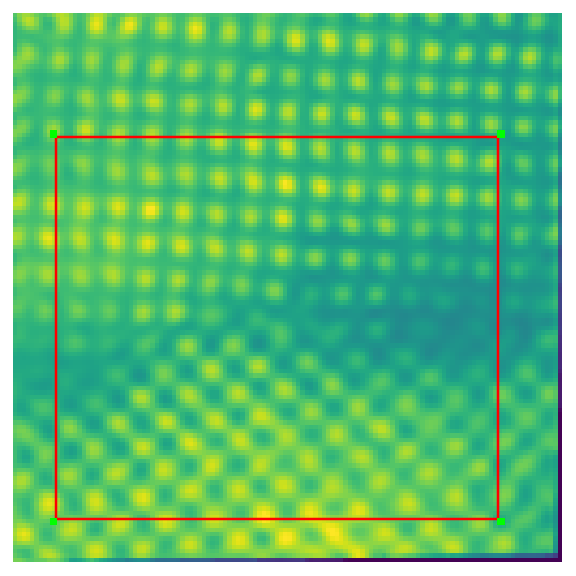

In [16]:
## Show the image for cropping
if crop_image == 1: 
    roi_rect = Pro.show_image_for_crop(image_DF,crop_style)  

In [17]:
## Save the value for cropping
if crop_image == 1:
    Pro.crop_txt(fold_name, roi_rect, apply_crop_image) 

In [18]:
## Load crop information
dataset_crop, path, crop = Pro.load_crop(fold_name,dataset,path,apply_crop_image)

# 5. Calculate center-of-mass (CoM) for each probe position

## 5.1 Determine the center beam mask

In [19]:
## Figures in the jupyter notebook ########################################################################################
%matplotlib inline 

Estimated probe radius = 11.77 pixels
Reciprocal scale (measured from the probe):1.02 (1/nm) / pixel
Reciprocal scale (measured from the probe):2.00 (mrad) / pixel


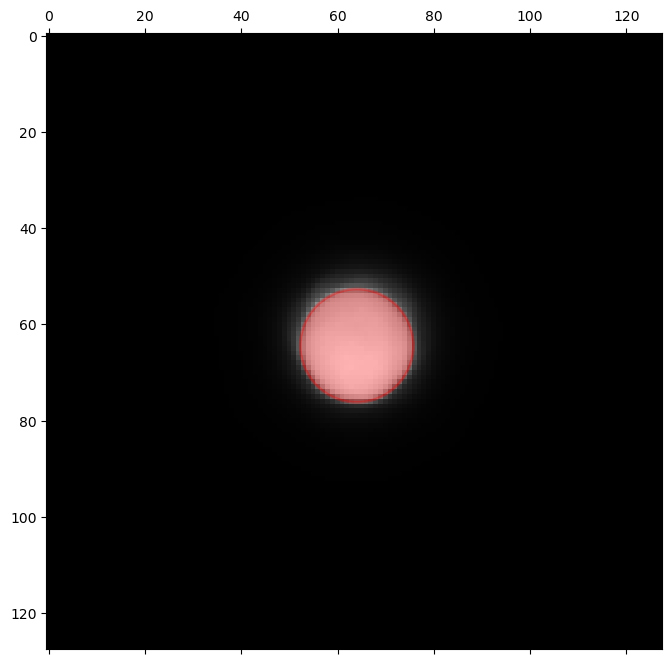

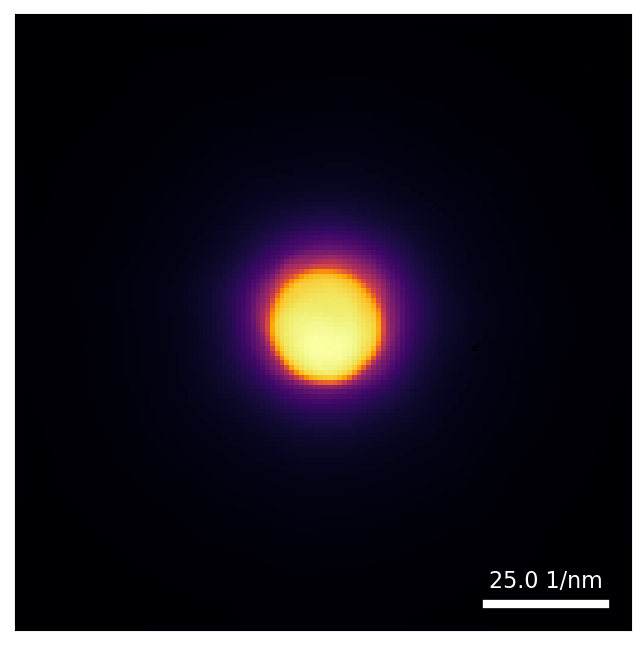

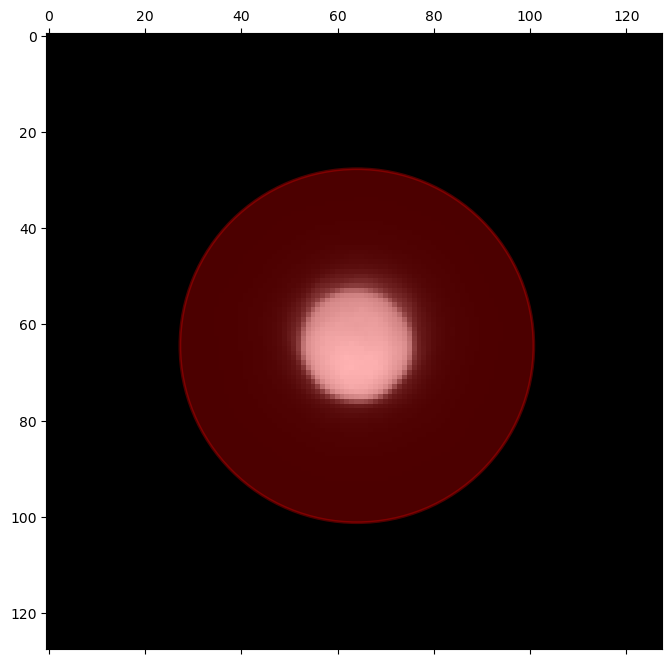

In [20]:
expand_BF_CoM = 25.0
probe_semiangle_crop, qx0_crop, qy0_crop,mask,recip_scale_1nm,recip_scale_mrad,_ = Pro.show_diffraction_patterns(
                                            dataset,path,aperture_mrad,voltage_kV,expand_BF_CoM,dataset_raw = dataset)

## 5.2 Show processed BF and DF images

100%|█████████████████████████████████████████████████████████████████████████| 16384/16384 [00:00<00:00, 30670.52it/s]


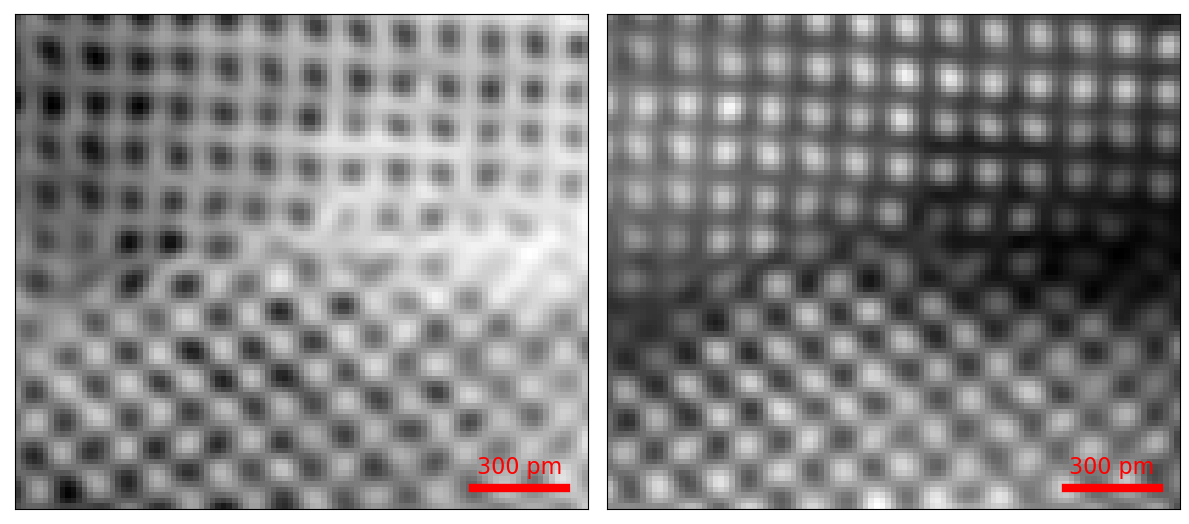

In [21]:
image_BF, image_DF = Pro.plot_processed_BF_DF_images(dataset,path,fold_name,name_extra,qx0_crop,qy0_crop,
  probe_semiangle_crop,expand_BF,det_DF,fft_clean,fft_type,fft_ratio,apply_drift_correction,real_scale_pm,scale_ratio,crop)

## 5.3 Plot processed CoM

Pass 1: Angle=18.0
Pass 2: Angle=10.8
Pass 3: Angle=12.2
Pass 4: Angle=12.3
Maximum x: 0.71 1/nm
Maximum x: 1.40 mrad


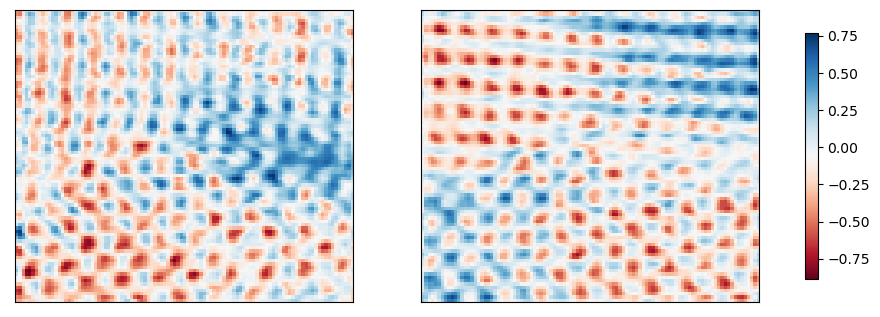

In [22]:
CoMx, CoMy = Pro.plot_processed_CoM(
                dataset,path,fold_name,real_scale_pm,recip_scale_1nm,apply_drift_correction,scale_ratio,crop,mask)
rCoMx, rCoMy = Pro.plot_processed_CoM_with_PL_rotation(path,real_scale_pm,recip_scale_1nm,CoMx,CoMy,
                apply_drift_correction,fft_clean_CoM,fft_type_CoM,fft_ratio_CoM,flip_key)
print('Maximum x: ' + '%.2f' % (rCoMx*recip_scale_1nm).max() + ' 1/nm')
print('Maximum x: ' + '%.2f' % (rCoMx*recip_scale_mrad).max() + ' mrad')

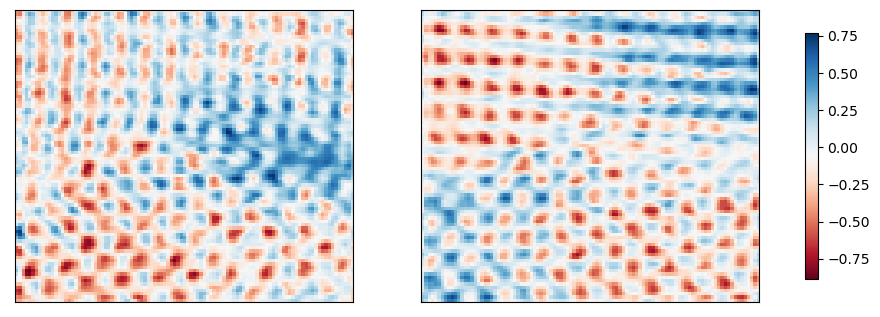

In [23]:
rCoMx,rCoMy = Pro.set_PL_rotation(path,real_scale_pm,recip_scale_1nm,rCoMx,rCoMy,apply_drift_correction,
                                  fft_clean_CoM,fft_type_CoM,fft_ratio_CoM,PLRotation = rotation)

# 6. Electric field map

## 6.1 Plot the electric field map

Pre-factor for calculating electric field: 0.07 V/pm (based on Ehrenfest theorem)
Pre-factor for calculating electric field: 0.07 V/pm (based on multislice algorithm)


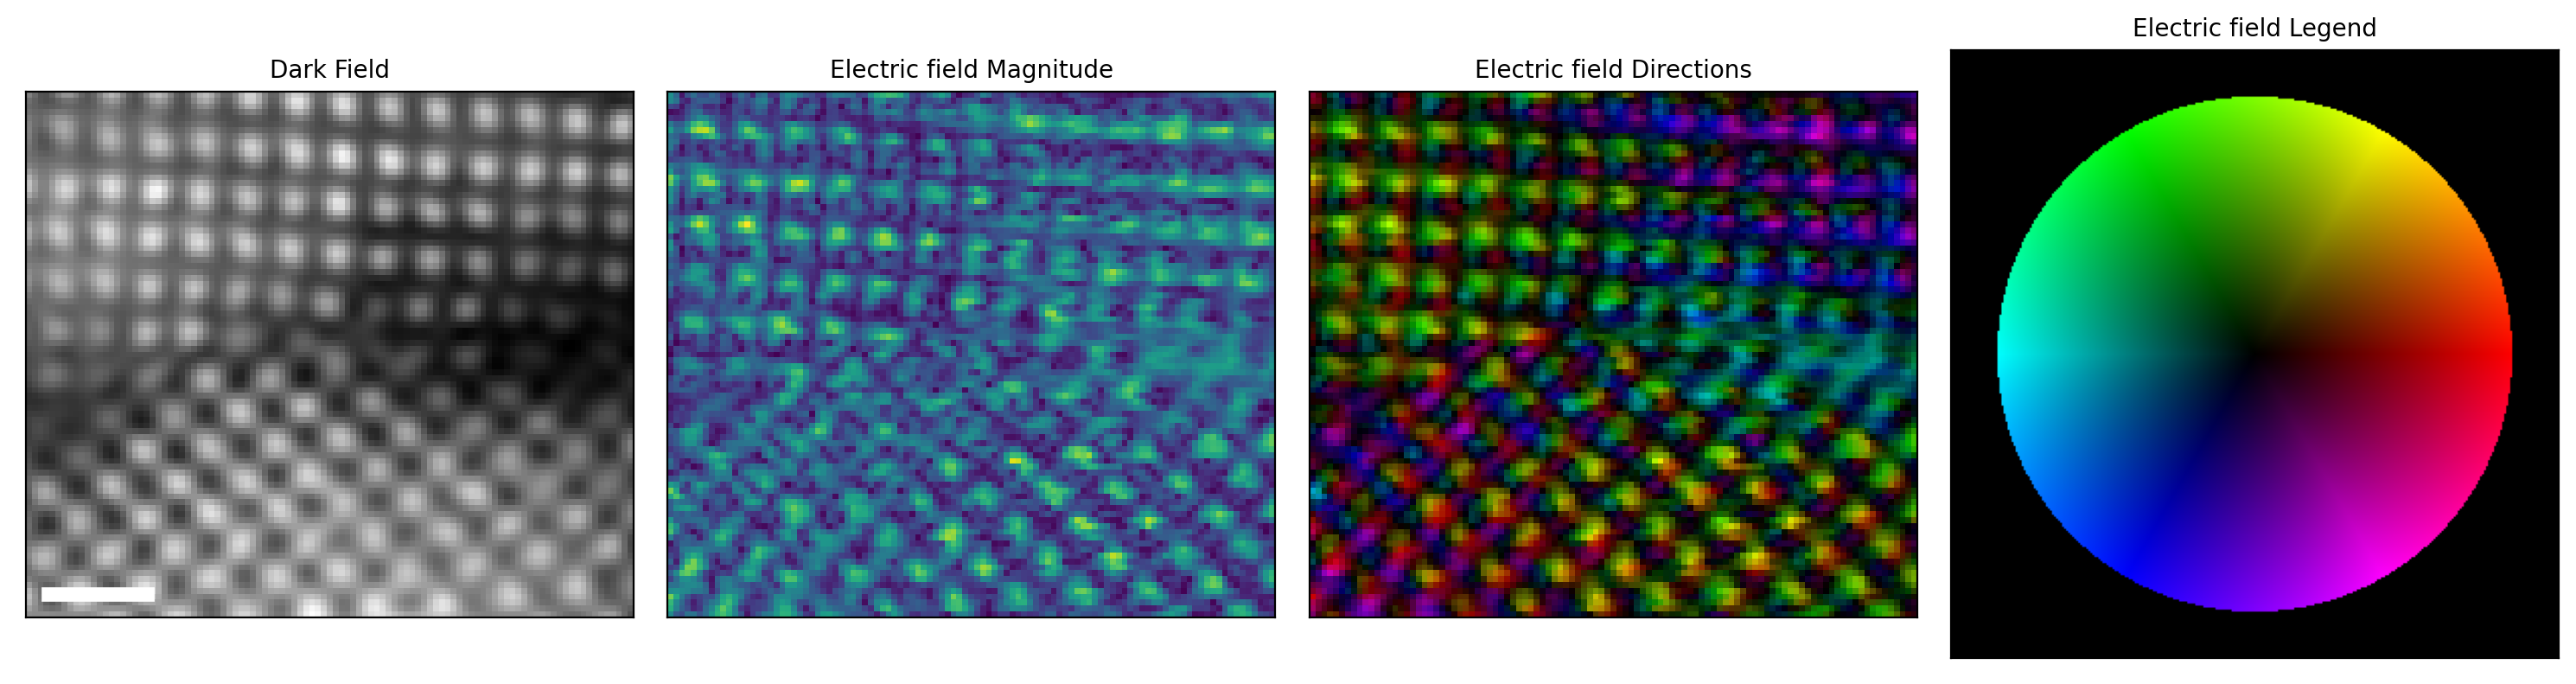

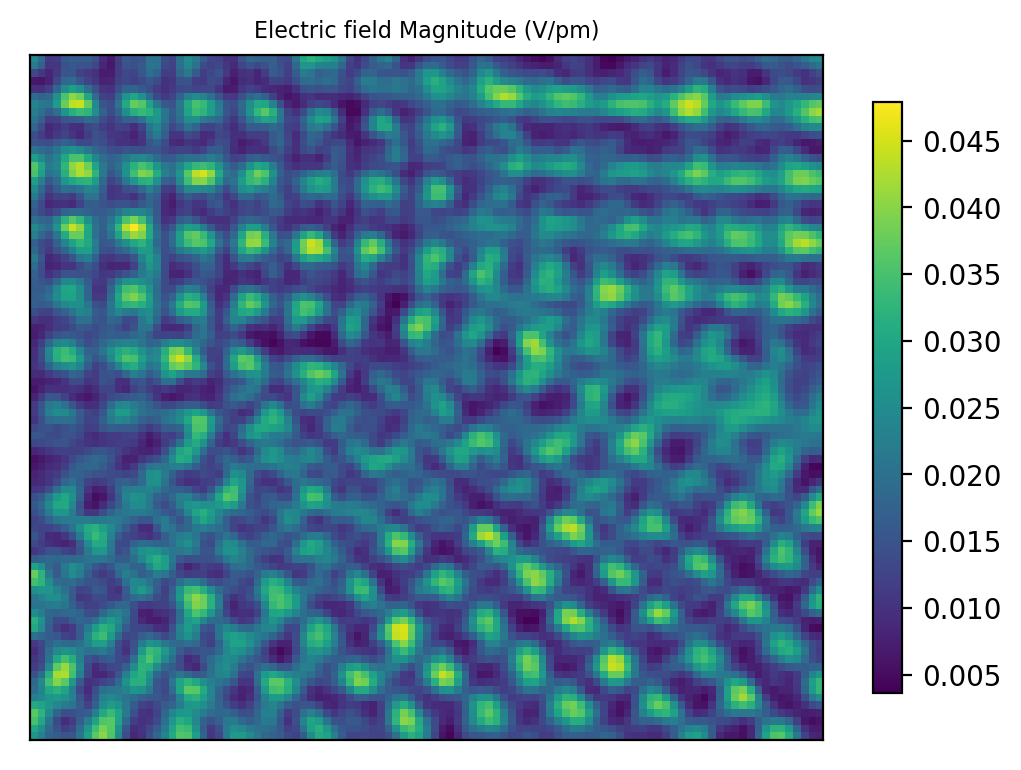

In [24]:
Pro.plot_eletric_field(path,rCoMx,rCoMy,name_extra_CoM,image_DF,real_scale_pm,voltage_kV,
                       thickness_nm,recip_scale_1nm,G_blur)

## 6.2 Plot the vector map

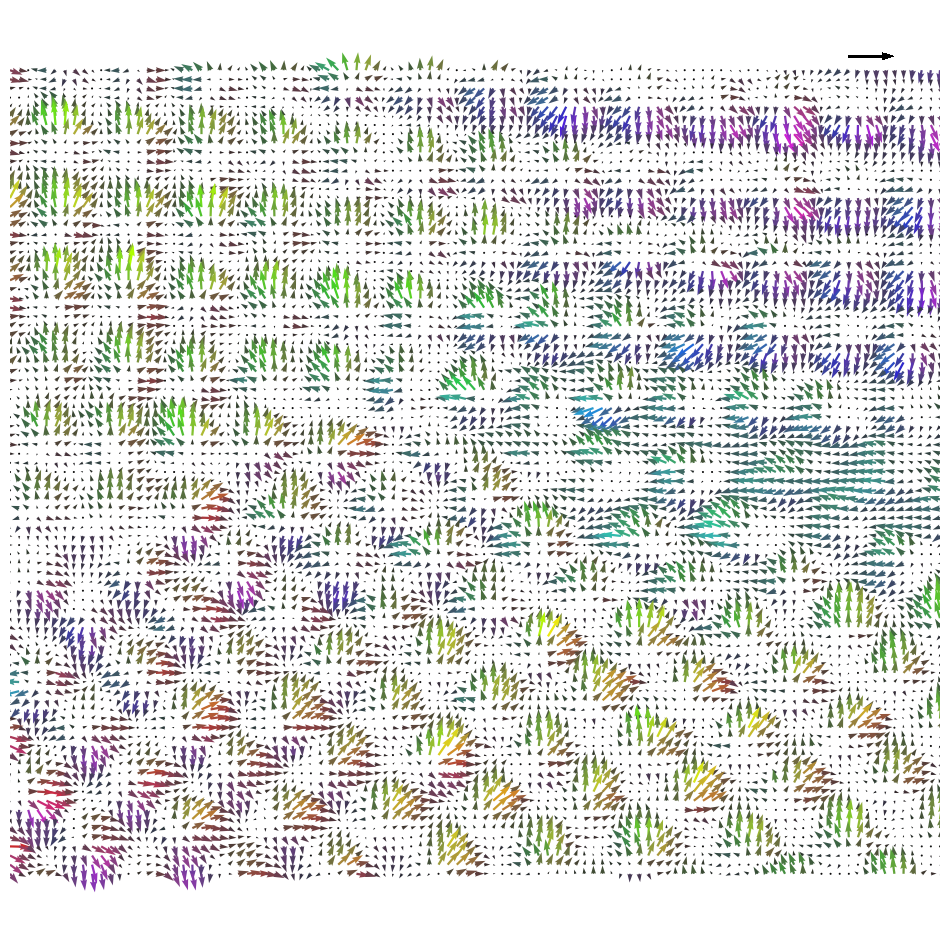

In [25]:
Pro.plot_vector(path,rCoMx,rCoMy,name_extra_CoM,voltage_kV,thickness_nm,recip_scale_1nm,crop,lkey,scalef)

# 7. Charge density map

## 7.1 Plot the divergence of the vector map

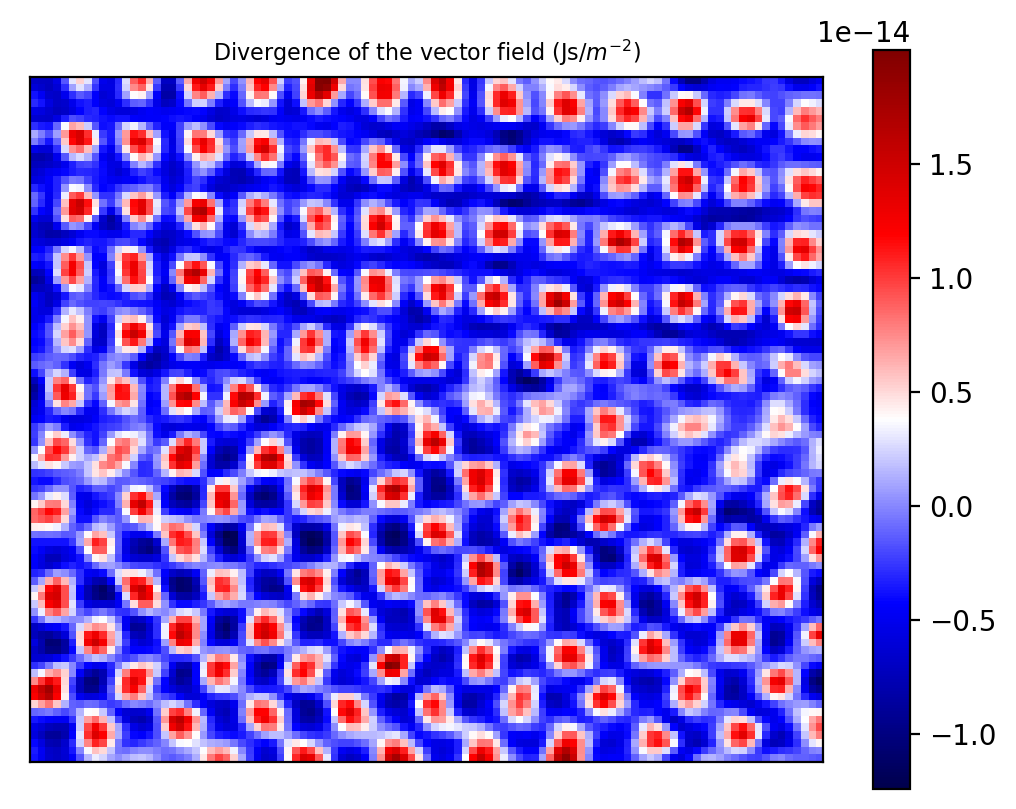

In [26]:
DivIm = Pro.plot_divergence_vector(path,rCoMx,rCoMy,name_extra_CoM,voltage_kV,
                                   thickness_nm,recip_scale_1nm,real_scale_pm,G_blur)

## 7.2 Plot the charge density map

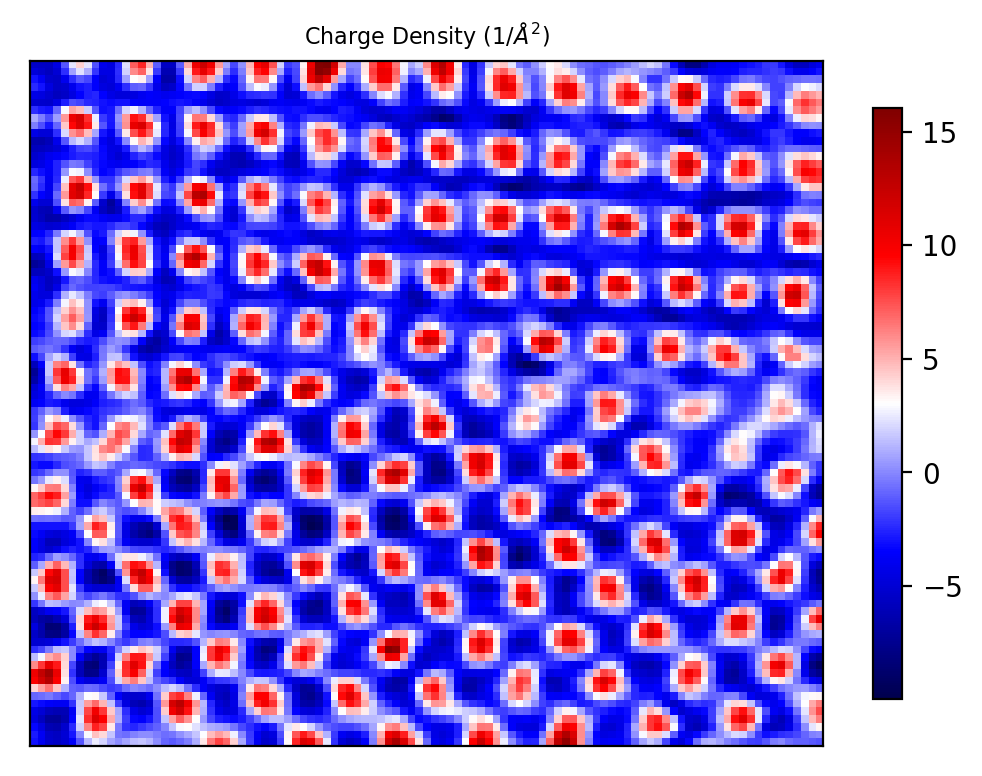

In [27]:
RhoIm = Pro.plot_charge_density(path,rCoMx,rCoMy,name_extra_CoM,voltage_kV,
                                thickness_nm,recip_scale_1nm,real_scale_pm,G_blur)

# 8. Potential map

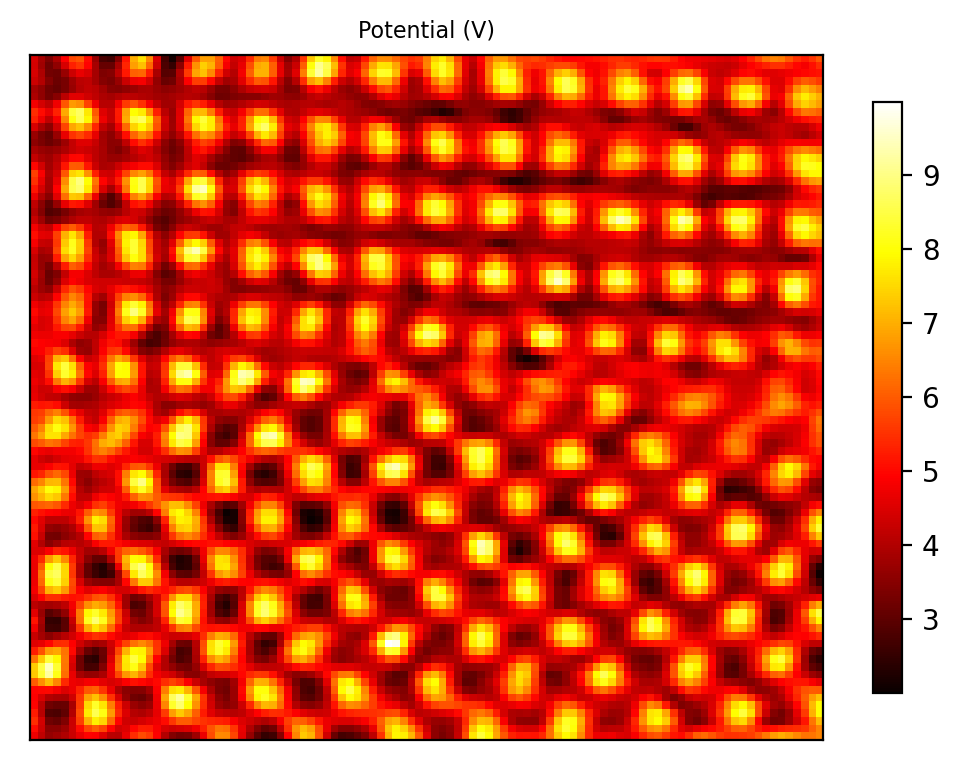

In [28]:
VIm = Pro.plot_potential(path,rCoMx,rCoMy,name_extra_CoM,voltage_kV,
                         thickness_nm,recip_scale_1nm,real_scale_pm,use_pass_filter_pot,lP=lP,hP=hP,G_blur=G_blur)

# Appendix

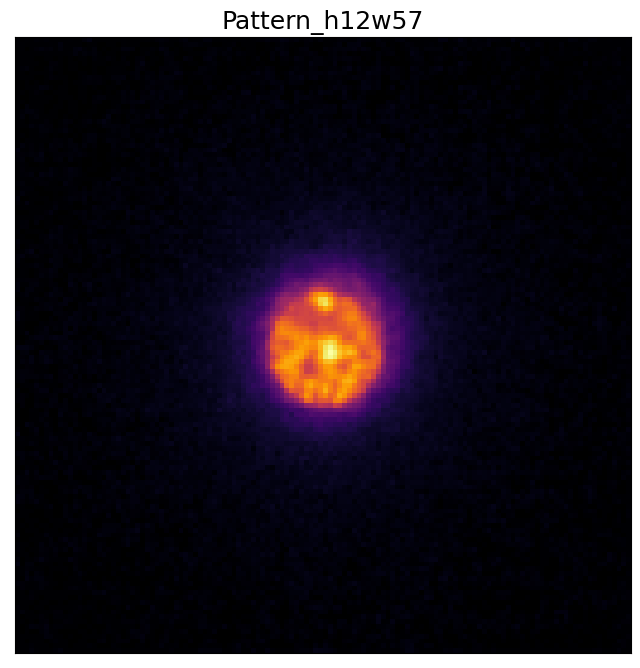

In [29]:
check_individual_DP = 1         # If check_individual_DF = 1, you can check
if check_individual_DP == 1:
    DP_h = 12
    DP_w = 57 
    Pro.check_DP(path,dataset_crop,DP_h,DP_w,recip_scale_1nm)   # check individual diffraction pattern

In [30]:
%matplotlib notebook

<IPython.core.display.Javascript object>


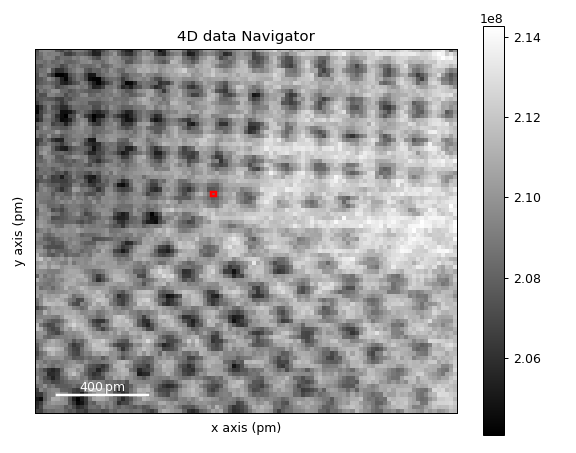

<IPython.core.display.Javascript object>


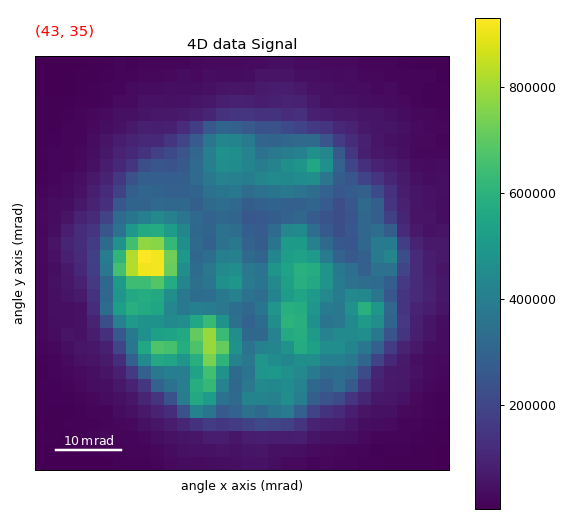

<PixelatedSTEM, title: 4D data, dimensions: (103, 89|32, 32)>

In [31]:
Pro.plot_4D(dataset_crop.data[:,:,48:80,48:80],real_scale_pm,recip_scale_mrad)